<a href="https://colab.research.google.com/github/hithasam24/FULLSTOPcyberbullyingdetection/blob/main/CyberBullyingDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from time import time
import pickle

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import plotly.graph_objs as go
import plotly.offline as py

In [6]:
df = pd.read_csv('/content/cyberbullying_tweets.csv')

In [7]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [9]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [10]:
df.shape[0]


47692

In [11]:
def performdatadistribution(df):
    total = df.shape[0]
    num_non_toxic = df[df['cyberbullying_type']=='not_cyberbullying'].shape[0]

    slices = [num_non_toxic/total, (total-num_non_toxic)/total]

    labeling = ['Non-Toxic', 'Toxic']

    explode = [0.2, 0]

    plt.pie(slices, explode = explode, shadow=True, autopct="%1.1f%%", labels = labeling, wedgeprops={'edgecolor': 'black'})

    plt.title('Number of Toxic Vs Non- Toxic Test Sample')

    plt.tight_layout()

    plt.show()

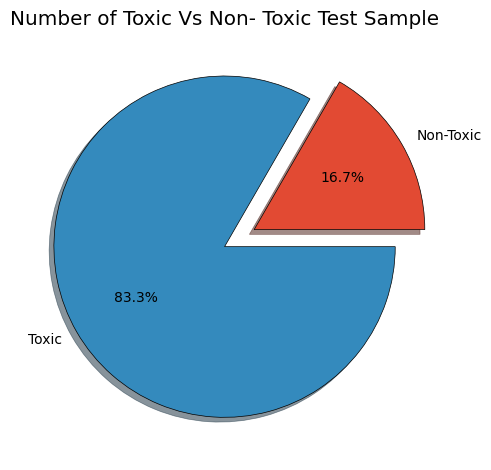

In [12]:
performdatadistribution(df)

In [15]:
def remove_pattern(input_txt, pattern):
    if (type(input_txt)==str):
        r = re.findall(pattern, input_txt)
        for i in r:
            input_txt = re.sub(i, '', input_txt)
        return input_txt
    else:
        return ""

In [16]:
df.head(1)

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying


In [35]:
def datasetCleaning(df):
    df['length_headline'] = df['tweet_text'].str.len()
    combined_df = pd.concat([df, df], ignore_index=True)
#     remove @ user
    combined_df['tidy_tweet'] = np.vectorize(remove_pattern)(combined_df['tweet_text'], "@[\w]*")

#     remove extra letters
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

#     remove all those words with size less than 3
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].apply(lambda x : ' '.join([w for w in x.split() if len(w)>3]))

    combined_df['length_tidy_tweet'] = combined_df['tidy_tweet'].str.len()

#     Tokenized
    tokenized_tweet = combined_df['tidy_tweet'].apply(lambda x : x.split())

    nltk.download('wordnet')

    lemmatizer = nltk.stem.WordNetLemmatizer()

    tokenized_tweet = tokenized_tweet.apply(lambda x :[lemmatizer.lemmatize(i) for i in x])

    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    combined_df['tidy_tweet'] = tokenized_tweet

    return combined_df, df


In [36]:
combined_df, df = datasetCleaning(df)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [37]:
combined_df.head()

,tweet_text,cyberbullying_type,length_headline,tidy_tweet,length_tidy_tweet
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61,"other word #katandandre, your food crapiliciou...",54
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,115,#aussietv white? #MKR #theblock #ImACelebrityA...,105
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60,classy whore? more velvet cupcakes?,35
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103,meh. thanks head concerned about another angry...,61
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103,This ISIS account pretending Kurdish account. ...,63


In [38]:
from sklearn.model_selection import train_test_split

In [40]:
def performdatasplit(x, y, combined_df, df):
    X_train, X_test, y_train, y_test = train_test_split(combined_df['tidy_tweet'], combined_df['cyberbullying_type'], test_size = x, random_state = y)
    print(f"Number of rows in the total dataset: {combined_df.shape[0]}")
    print(f"Number of rows in the train dataset: {X_train.shape[0]}")
    print(f"Number of rows in the test dataset: {X_test.shape[0]}")

    files = open("stopwords.txt" , "r")
    content = files.read()
    content_list = content.split("\n")
    files.close()

    tfidfvector = TfidfVectorizer(stop_words=content_list, lowercase=True)

    training_data = tfidfvector.fit_transform(X_train.values.astype('U'))

    testing_data = tfidfvector.transform(X_test.values.astype('U'))

    filename = 'tfidfvectoizer.pkl'

    pickle.dump(tfidfvector.vocabulary_, open(filename, 'wb'))

    return X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list

In [52]:
X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list = performdatasplit(0.2, 42, combined_df, df)



Number of rows in the total dataset: 95384
Number of rows in the train dataset: 76307
Number of rows in the test dataset: 19077


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.



In [53]:
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [45]:
def pipeline(X_train, y_train, X_test, y_test):
    MODELS = [LinearSVC(), LogisticRegression(), MultinomialNB(), DecisionTreeClassifier(),
              AdaBoostClassifier(), BaggingClassifier(), SGDClassifier()]

    size = len(y_train)

    results = {}

    final_result = []

    for model in MODELS:
        results['Algorithm'] = model.__class__.__name__

        start = time()
        print(f"Training Time : {model.__class__.__name__}")
        model.fit(X_train, y_train)
        end = time()

        filename = model.__class__.__name__+".pkl"
        pickle.dump(model, open(filename, "wb"))

        results['Training Time'] = end - start

        start = time()
        prediction_test = model.predict(X_test)
        prediction_train = model.predict(X_train)
        end = time()

        results['Prediction Time'] = end - start

        results['Accuracy : Test'] = accuracy_score(y_test, prediction_test)
        results['Accuracy : Train'] = accuracy_score(y_train, prediction_train)

        # Changed lines to use 'weighted' average for multiclass
        results['F1 Score : Test'] = f1_score(y_test, prediction_test, average='weighted')
        results['F1 Score : Train'] = f1_score(y_train, prediction_train, average='weighted')
        results['Precision : Test'] = precision_score(y_test, prediction_test, average='weighted')
        results['Precision : Train'] = precision_score(y_train, prediction_train, average='weighted')
        results['Recall : Test'] = recall_score(y_test, prediction_test, average='weighted')
        results['Recall : Train'] = recall_score(y_train, prediction_train, average='weighted')

        print(f"Training {model.__class__.__name__} finished in {results['Training Time']} sec")

        final_result.append(results.copy())
    return final_result

In [54]:
final_result = pipeline(training_data, y_train, testing_data, y_test)

Training Time : LinearSVC
Training LinearSVC finished in 4.554708242416382 sec
Training Time : LogisticRegression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training LogisticRegression finished in 15.194568634033203 sec
Training Time : MultinomialNB
Training MultinomialNB finished in 0.21653342247009277 sec
Training Time : DecisionTreeClassifier
Training DecisionTreeClassifier finished in 26.217578649520874 sec
Training Time : AdaBoostClassifier
Training AdaBoostClassifier finished in 13.792200326919556 sec
Training Time : BaggingClassifier
Training BaggingClassifier finished in 246.05297875404358 sec
Training Time : SGDClassifier
Training SGDClassifier finished in 0.9473376274108887 sec


In [55]:
def performfinalresult(final_results):
    results = pd.DataFrame(final_results)
    results.reindex(columns = ['Algorithm', 'Accuracy : Test', 'Precision : Test', 'Recall : Test', 'F1 Score : Test', 'Prediction Time',
                          'Accuracy : Train', 'Precision : Train', 'Recall : Train', 'F1 Score : Train', 'Training Time'])
    results.sort_values(by = 'F1 Score : Test', inplace=True, ascending=False)

    return results

In [56]:
results = performfinalresult(final_result)
results.reset_index(drop = True)

,Algorithm,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
0,DecisionTreeClassifier,26.217579,0.115004,0.906065,0.964276,0.906583,0.964179,0.907179,0.964707,0.906065,0.964276
1,BaggingClassifier,246.052979,1.390576,0.903234,0.961629,0.903981,0.961744,0.905318,0.962098,0.903234,0.961629
2,LinearSVC,4.554708,0.022437,0.889920,0.944409,0.889982,0.944353,0.891260,0.945580,0.889920,0.944409
3,LogisticRegression,15.194569,0.041809,0.855900,0.905395,0.858805,0.906441,0.863721,0.908562,0.855900,0.905395
4,SGDClassifier,0.947338,0.029472,0.843005,0.877665,0.840845,0.875758,0.844588,0.878569,0.843005,0.877665
5,MultinomialNB,0.216533,0.021514,0.807569,0.851717,0.796781,0.844909,0.801320,0.850641,0.807569,0.851717
6,AdaBoostClassifier,13.792200,1.961560,0.634901,0.634254,0.648087,0.645544,0.771972,0.769782,0.634901,0.634254


In [57]:
results.describe().loc[['min', 'max'], :]

,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
min,0.216533,0.021514,0.634901,0.634254,0.648087,0.645544,0.771972,0.769782,0.634901,0.634254
max,246.052979,1.961560,0.906065,0.964276,0.906583,0.964179,0.907179,0.964707,0.906065,0.964276


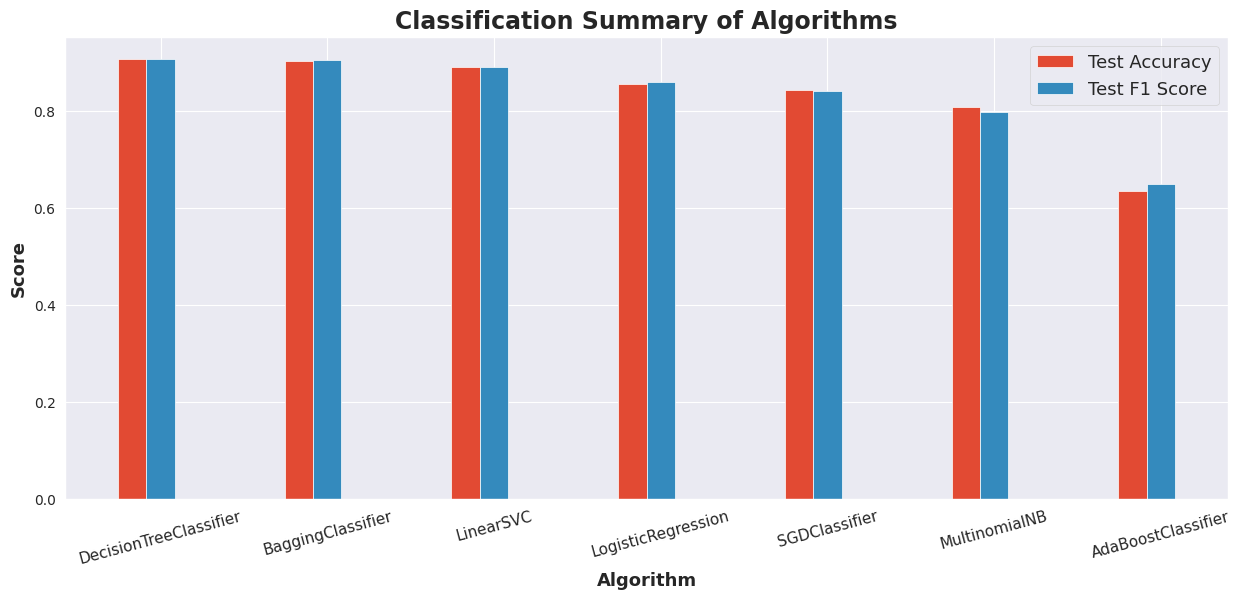

In [58]:
best_acc = results[results['Accuracy : Test'] == results['Accuracy : Test'].max()]
best_f1 = results[results['F1 Score : Test'] == results['F1 Score : Test'].max()]
best_precision = results[results['Precision : Test'] == results['Precision : Test'].max()]
best_recall = results[results['Recall : Test'] == results['Recall : Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (15, 6))

barWidth = 0.17

# set height of bar
bars1 = results['Accuracy : Test']
bars2 = results['F1 Score : Test']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Test F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)

# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy : Test'].values[0], best_acc['Algorithm'].values[0]),
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score : Test'].values[0], best_f1['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

Text(0.5, 1.0, 'Training and Prediction time of Algorithms')

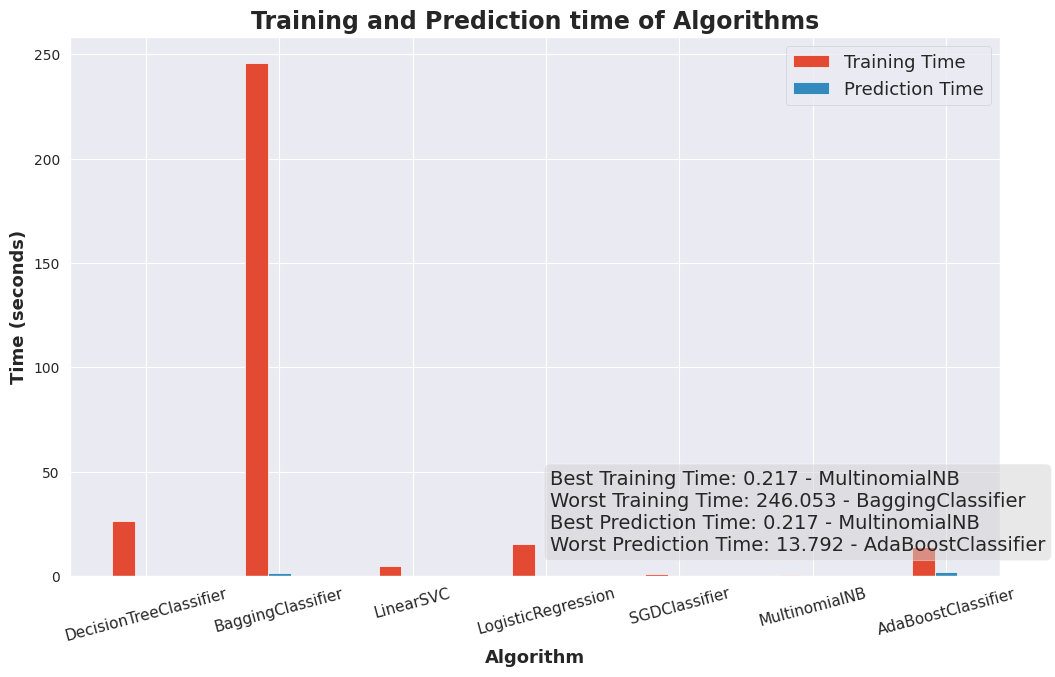

In [59]:
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

plt.figure(figsize = (12, 7))

barWidth = 0.17

# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)


textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]),
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]),
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(3.2, 12, textstr, fontsize=14,  bbox=props)

# Create legend & Show graphic
plt.legend(fontsize = 13)
plt.title('Training and Prediction time of Algorithms', fontweight = 'bold', fontsize = 17)

In [60]:
df.head()

,tweet_text,cyberbullying_type,length_headline
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,115
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103


In [67]:
data = ["you are so beautiful"]

tfidf_vector = TfidfVectorizer(stop_words=content_list, lowercase=True, vocabulary=pickle.load(open("tfidfvectoizer.pkl", "rb")))
preprocessed_data = tfidf_vector.fit_transform(data)

trained_model = pickle.load(open('LinearSVC.pkl', 'rb'))
print(trained_model.predict(preprocessed_data))

if(trained_model.predict(preprocessed_data)=="not_cyberbullying"):
    print("not bullying")
elif(trained_model.predict(preprocessed_data)=="gender"):
    print("bullying due to gender")
elif(trained_model.predict(preprocessed_data)=="religion"):
    print("bullying due to religion")
elif(trained_model.predict(preprocessed_data)=="ethnicity"):
    print("bullying due to ethnicity")
elif(trained_model.predict(preprocessed_data)=="age"):
    print("bullying due to age")
else:
    print("other bullying")


['gender']
bullying due to gender


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:1368: UserWarning:

Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.



In [73]:
from sklearn.model_selection import GridSearchCV

def tuning(clf, param_dict, X_train, y_train, X_test, y_test):
    scorer = make_scorer(f1_score, average='weighted') # Changed to use 'weighted' average

    grid_obj = GridSearchCV(estimator=clf, param_grid=param_dict, scoring=scorer, cv=5)

    grid_fit = grid_obj.fit(X_train, y_train)

    best_clf = grid_fit.best_estimator_

    prediction = (clf.fit(X_train, y_train)).predict(X_test)

    best_prediction = best_clf.predict(X_test)

    print(clf.__class__.__name__)
    print(f"Best Parameter:  {grid_fit.best_params_}")

    print(f"Accuracy:  {accuracy_score(y_test, best_prediction)}")

    # Changed lines to use 'weighted' average for multiclass
    print(f"F1 Score :  {f1_score(y_test, best_prediction, average='weighted')}")

    print(f"Precision :  {precision_score(y_test, best_prediction, average='weighted')}")

    print(f"Recall:  {recall_score(y_test, best_prediction, average='weighted')}")

In [74]:
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_model = LinearSVC()

tuning(clf_model, param_grid, training_data, y_train, testing_data, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 207, in _get_response_values
    raise ValueError(
ValueEr

LinearSVC
Best Parameter:  {'C': 0.25}
Accuracy:  0.8720448707868114
F1 Score :  0.8729187693165794
Precision :  0.8747323639576876
Recall:  0.8720448707868114


In [75]:
pickle.dump(clf_model, open("LinearSVCTuned.pkl", "wb"))